In [1]:
import numpy as np
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
data = pd.read_csv('NSW-Table 1 2 3.csv')
data.head()

,Row Labels,Count of Crash ID,Month
0,1989,55,1
1,1989,82,2
2,1989,82,3
3,1989,45,4
4,1989,77,5


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

data['Date'] = pd.to_datetime(data['Row Labels'].astype(str) + '-' + data['Month'].astype(str))

# Sort by date
data = data.sort_values('Date')

# Set the date as the index
data.set_index('Date', inplace=True)

# Drop unnecessary columns
data = data[['Count of Crash ID']]

# Normalize the data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# Convert scaled data back to dataframe
data_scaled = pd.DataFrame(data_scaled, index=data.index, columns=['Count of Crash ID'])

In [4]:
# Create features based on the data from the same month in the past three years
def create_lag_features(df, lags):
    for lag in lags:
        df[f'Lag_{lag}'] = df['Count of Crash ID'].shift(lag)
    return df

# Use lags of 12, 24, and 36 months (1, 2, and 3 years)
lags = [12,24,36]
data = create_lag_features(data_scaled, lags)

# Drop rows with NaN values
data.dropna(inplace=True)

# Split the data into training and testing sets
train_data = data[:'2020']
test_data = data['2021':'2023']

X_train = train_data.drop('Count of Crash ID', axis=1)
y_train = train_data['Count of Crash ID']
X_test = test_data.drop('Count of Crash ID', axis=1)
y_test = test_data['Count of Crash ID']


In [5]:
# Define the XGBoost model
model = XGBRegressor(objective='reg:squarederror', n_estimators=10000, learning_rate=1)

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Calculate RMSE
# Define a function to calculate MAPE with a threshold to avoid division by zero
def mean_absolute_percentage_error(y_true, y_pred):
    mask = y_true != 0  # Avoid division by zero
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

# Calculate MAPE
mape_train = mean_absolute_percentage_error(y_train, y_pred_train)
mape_test = mean_absolute_percentage_error(y_test, y_pred_test)
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
mae_train = mean_absolute_error(y_train, y_pred_train)
mae_test = mean_absolute_error(y_test, y_pred_test)




# Print evaluation metrics

print(f'Training RMSE: {rmse_train}')
print(f'Testing RMSE: {rmse_test}')
print(f'Training MAE: {mae_train}')
print(f'Testing MAE: {mae_test}')
print(f'Training MAPE: {mape_train}')
print(f'Testing MAPE: {mape_test}')



Training RMSE: 0.0014038642419838513
Testing RMSE: 0.08483507935482108
Training MAE: 0.0009886903209651511
Testing MAE: 0.0715645554933756
Training MAPE: 0.507576109997509
Testing MAPE: 90.06684625664286


In [6]:
# Create a dataframe for future predictions
future_dates = pd.date_range(start='2024-01-01', end='2050-12-01', freq='MS')
future_data = pd.DataFrame(index=future_dates)

# Initialize with the latest known data
last_known_data = data.iloc[-36:].copy()

# Initialize future data
future_data['Lag_12'] = np.nan
future_data['Lag_24'] = np.nan
future_data['Lag_36'] = np.nan


# Initialize future_predictions list
future_predictions = []

# Fill the lag features step by step
for i in range(len(future_data)):
    if i < 12:
        future_data.iloc[i, future_data.columns.get_loc('Lag_12')] = last_known_data.iloc[-12 + i]['Count of Crash ID']
    else:
        future_data.iloc[i, future_data.columns.get_loc('Lag_12')] = future_predictions[i - 12]
        
    if i < 24:
        future_data.iloc[i, future_data.columns.get_loc('Lag_24')] = last_known_data.iloc[-24 + i]['Count of Crash ID']
    else:
        future_data.iloc[i, future_data.columns.get_loc('Lag_24')] = future_predictions[i - 24]
        
    if i < 36:
        future_data.iloc[i, future_data.columns.get_loc('Lag_36')] = last_known_data.iloc[-36 + i]['Count of Crash ID']
    
    else:
        future_data.iloc[i, future_data.columns.get_loc('Lag_36')] = future_predictions[i - 36]
    
    
    # Make prediction for the current step
    current_prediction = model.predict(future_data.iloc[i:i+1].dropna(axis=1))
    future_predictions.append(current_prediction[0])

# Rescale future predictions back to original scale
future_predictions_rescaled = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Create a dataframe for future predictions to plot
future_data['Count of Crash ID'] = future_predictions_rescaled


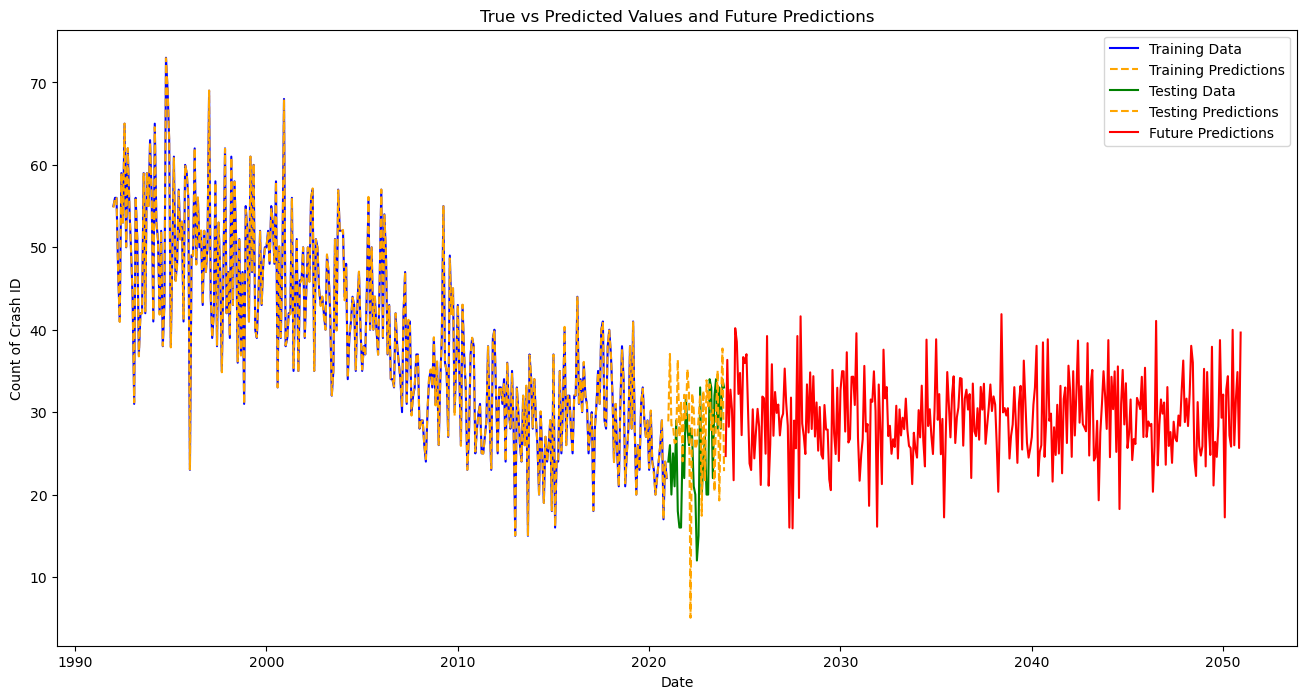

In [7]:
# Plot the results
plt.figure(figsize=(16, 8))

# Plot training data and predictions
plt.plot(y_train.index, scaler.inverse_transform(y_train.values.reshape(-1, 1)), label='Training Data', color='blue')
plt.plot(y_train.index, scaler.inverse_transform(y_pred_train.reshape(-1, 1)), label='Training Predictions', linestyle='--', color='orange')

# Plot testing data and predictions
plt.plot(y_test.index, scaler.inverse_transform(y_test.values.reshape(-1, 1)), label='Testing Data', color='green')
plt.plot(y_test.index, scaler.inverse_transform(y_pred_test.reshape(-1, 1)), label='Testing Predictions', linestyle='--', color='orange')

# Plot future predictions
plt.plot(future_data.index, future_data['Count of Crash ID'], label='Future Predictions', color='red')

plt.title('True vs Predicted Values and Future Predictions')
plt.xlabel('Date')
plt.ylabel('Count of Crash ID')
plt.legend()
plt.show()
